<h2>PARTE EN SUCIO</h2>

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

In [19]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [20]:
partida = lectura('../output/output1.json')

In [21]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [22]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    componentes_conexas = list(nx.connected_components(grafo))

    # Encontrar la componente conexa más grande
    tamanos_componentes = [len(componente) for componente in componentes_conexas]
    indice_componente_a_conservar = tamanos_componentes.index(max(tamanos_componentes))
    componente_a_conservar = list(componentes_conexas[indice_componente_a_conservar])

    # Crear un nuevo grafo con solo la componente conexa más grande
    G_componente_grande = grafo.subgraph(componente_a_conservar).copy()
    for r in diccionario.copy():
        if r not in G_componente_grande:
            diccionario.pop(r)
    return G_componente_grande

In [23]:
mapa = genera_grafo(partida)

In [24]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [25]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [26]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [27]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [28]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [29]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [30]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [31]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [32]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [33]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

In [34]:
posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}

---
<h2><a name="Ubicacion"></a><strong>3. Ubicaciones de la capital</strong></h2>
<p>Ahora que conocemos nuestra galaxia y nos hemos podido abrir paso extendiendo nuestros dominios, llega un punto en el que debemos ubicar aquel sistema que será la <strong>capital</strong> de nuestro <strong>futuro imperio</strong>. El problema se basa en qué sistema o por qué lugar nos vendría bien situar nuestra capital, que esté lo más centrado posible para poder llegar rápidamente a cualquier lugar conquistado o incluso para poder defenderlo fácilemente de cualquier ataque enemigo.</p>
<p>Nos centraremos más en encontrar los sistemas perfectos para asignarles nuestra capital.</p>
<p>Mediante la función que se mostrará más tarde, <em>mejor_opcion()</em>, podremos ver los mejores lugares del imperio para colocar una capital.</p>
<p>Primero debemos plantear el problema de dónde situar la capital.</p>
<br><strong>LÓGICA PARA ABORDAR EL PROBLEMA</strong></br>
<p>Una manera lógica de averiguar cuáles son las mejores opciones y las peores es empleando <strong>teoría de excentricidad</strong>. Como las periferias de un imperio son las zonas con <strong>mayor dificultad de acceso</strong>, es lógico que se consideren como las peores opciones. A contra parte de la periferia, el centro tiene <strong>mayor accesibilidad</strong> desde cualquier parte de nuestro imperio. Por ende consideraremos el estudio del centro como la mejor opción.</p>
<p>No hay mejor lugar para colocar nuestra capital que en un sistema el cuál se puedan <strong>acceder</strong> a todos los lugares de nuestro imperio de una manera más <strong>eficiente</strong> y <strong>rápida</strong>, sin perder nuestro tiempo en defendernos o incluso enviar el apoyo de nuestras tropas a la hora de conquistar.</p>

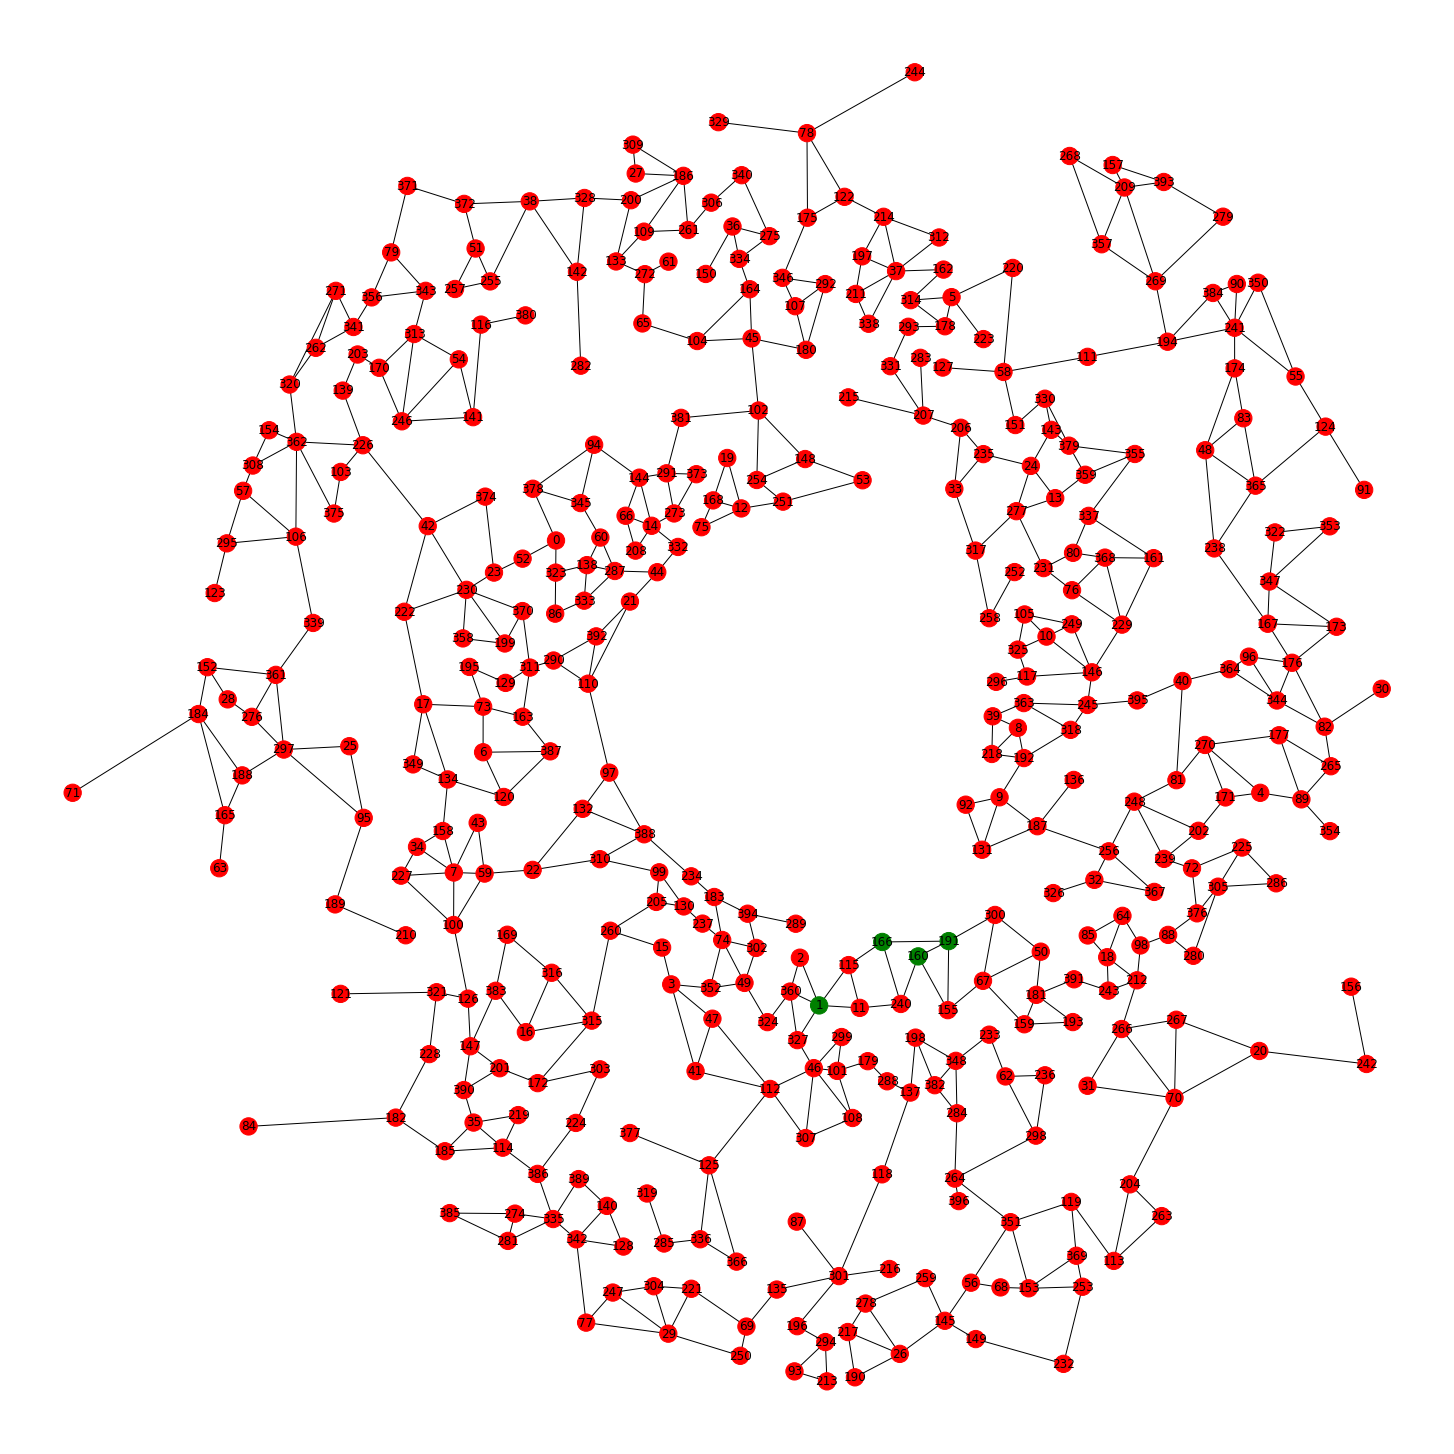

In [35]:
centro = nx.center(mapa_completo)
periferia = nx.periphery(mapa_completo)
colores={node: 'green' if node in centro else 'red' for node in mapa_completo.nodes()}
plt.figure(figsize=(20, 20))
nx.draw(mapa_completo, with_labels=True, node_color=[colores[node] for node in mapa_completo.nodes()], pos = posiciones)
plt.show()

<br><strong>MEJOR SOLUCIÓN</strong></br>

<p>Como es posible que salgan demasiadas posibilidades, para poder decidir la mejor capital, eliminaremos los nodos de la periferia ya que al ser los más dificiles de acceder, son los que más posibilidades tienen de ser conquistados. Así en caso de ser conquistados asegurarnos que la capital sigue estando en un punto fácilmente defendible.</p>
<p>Aquí es donde entra la función ya mencionada previamente: <em>mejor_opcion()</em>.</p>

In [36]:
def mejor_opcion(g):
    """
    Encuentra iterativamente el centro de un grafo al eliminar vértices periféricos
    hasta que el tamaño del centro sea igual a 1 o se encuentre un conjunto minimo a escoger

    Parameters:
        - g: Grafo de entrada.

    Returns:
        Un conjunto de vértices que constituyen el centro del grafo.
    """
    
    # Se crea una copia del grafo original para evitar modificar el grafo original
    G = g.copy()
    
    # Se ejecuta un bucle mientras el tamaño del centro del grafo no sea igual a 1, es decir, un unico nodo importante
    while not len(nx.center(G))==1:
        # Se verifica si el conjunto de vértices periféricos es vacío o si el radio es igual al diámetro, para saber si hemos acabado
        if not (len(nx.periphery(G)) == 0 or nx.radius(G) == nx.diameter(G)):
            # En caso afirmativo, se itera sobre los vértices periféricos y se elimina cada uno de ellos
            for v in nx.periphery(G):
                G.remove_node(v)
        else:
            # Si no se cumple la condición anterior, se rompe el bucle
            break
    return nx.center(G)

In [37]:
mejor_opcion(mapa_completo)

[44]

### Ejercicio 2:
<p>Utilizando los métodos y atributos disponibles, responde a las siguientes preguntas referentes al grafo G2 definido: ¿Cuáles son las posibles capitales de G2? ¿Cuál o cuáles son las mejores opciones?</p>

[]

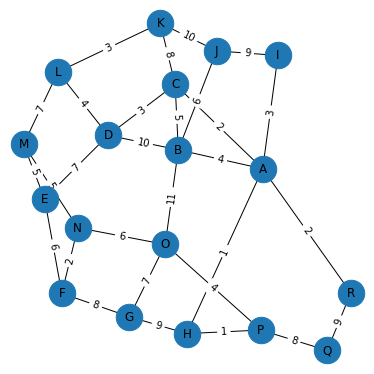

In [38]:
#Este es el grafo que representa el pais
G2 = nx.Graph()

# Agregar nodos al grafo
G2.add_nodes_from(["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R"])

# Agregar aristas con pesos al grafo
G2.add_edge("A", "B", weight=4)
G2.add_edge("A", "C", weight=2)
G2.add_edge("B", "C", weight=5)
G2.add_edge("B", "D", weight=10)
G2.add_edge("C", "D", weight=3)
G2.add_edge("D", "E", weight=7)
G2.add_edge("E", "F", weight=6)
G2.add_edge("F", "G", weight=8)
G2.add_edge("G", "H", weight=9)
G2.add_edge("H", "A", weight=1)
G2.add_edge("A", "I", weight=3)
G2.add_edge("B", "J", weight=6)
G2.add_edge("C", "K", weight=8)
G2.add_edge("D", "L", weight=4)
G2.add_edge("E", "M", weight=5)
G2.add_edge("F", "N", weight=2)
G2.add_edge("G", "O", weight=7)
G2.add_edge("H", "P", weight=1)
G2.add_edge("I", "J", weight=9)
G2.add_edge("J", "K", weight=10)
G2.add_edge("K", "L", weight=3)
G2.add_edge("L", "M", weight=7)
G2.add_edge("M", "N", weight=5)
G2.add_edge("N", "O", weight=6)
G2.add_edge("O", "P", weight=4)
G2.add_edge("P", "Q", weight=8)
G2.add_edge("Q", "R", weight=9)
G2.add_edge("R", "A", weight=2)
G2.add_edge("A", "I", weight=3)
G2.add_edge("B", "J", weight=6)
G2.add_edge("B", "O", weight=11)

plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G2)  # Layout para posicionar los nodos
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700)
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.plot()

<p><strong>SOLUCIÓN</strong></p>
<p>(Se puede borrar estos apartados después, es para mostrar la solución al problema)</p>

[]

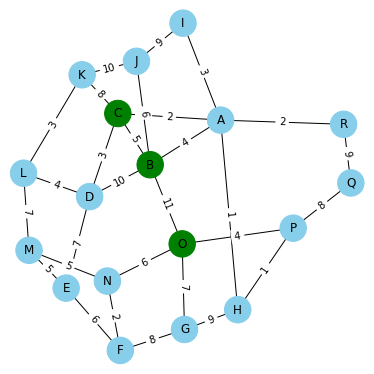

In [39]:
centro = nx.center(G2)

plt.figure(figsize=(5, 5))
nodo_pos = nx.spring_layout(G2)  # Layout para posicionar los nodos
nodo_colores = ["green" if nodo in centro else "skyblue" for nodo in G2.nodes]
nx.draw(G2, pos=nodo_pos, with_labels=True, node_size=700, node_color=nodo_colores)
nx.draw_networkx_edge_labels(G2, pos=nodo_pos, edge_labels=nx.get_edge_attributes(G2, 'weight'))
plt.plot()

In [40]:
mejor_opcion(G2)

['B']

### Propuesta
<p>Existen más formas de estudiar la centralidad de un grafo, tales como <em>eigenvector, pagerank</em> y <em>betweenneess</em>. Estas funciones los podemos encontrar en la página de <strong>Ciencia de Datos</strong>, concretamente en la sección <em><a href='https://cienciadedatos.net/documentos/pygml03-analisis-redes-python-networkx'>Análisis de redes con Python y NetworkX</a></em>.</p>
<p>Estudia la centralidad del grafo aplicando las funciones nombradas previamente.</p>

In [41]:
# Usando eigenvector

In [42]:
# Usando pagerank

In [43]:
# Usando betweennees